# Normality test

by Tonatiuh Rangel    

## Contents   
1. [Standarize data](#section1)
2. [Q - Q test](#section2)   
3. [Skew and kurtosis test](#section3)   
5. [Kolmogorov-Smirnov test](#section4)   
6. [Shapiro-Wilk test](#Shapiro_Wilk_test)    
7. [Anderson-Darling test](#Anderson_Darling_test)  


In this notebook, I go through several normality tests.   
The goal here is to test whether a given distribution is normal.   

<a id='section1'></a>
## Standarize data
For this notebook, I use a dataset of documents, containing the document id, and its readability score.   
The readability score tells how complex is a text to be read.   
The contents of the dataset are not important here.   


In [1]:
# This is to print in markdown style
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

import pandas as pd

# Read dataset locally
#df = pd.read_csv('../data/db-readability-length.csv', index_col=0)

# Read dataset from url:
import io
import requests
url="https://raw.githubusercontent.com/trangel/stats-with-python/master/data/db-readability-length.csv"
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')),index_col=0)


del df['Length']
X = df['Readability'].values
df.head()


,Readability
post id,
0,11.6
1,6.9
2,6.3
3,4.0
4,9.2


In [2]:
import numpy as np
# Sometimes it's important to remove outliers, as some of the tests don't work in presence of outliers
# Only keep data in range 1 to 99 th percentile:
X = df[df['Readability'].between(np.percentile(X,1), np.percentile(X,99), inclusive=True )].values


In [3]:
# Standarize and sort data
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()

X = X.reshape(len(X))
X = scaler.fit_transform(X)
X = np.sort(X)



/Users/rangel/anaconda3/envs/cdips2017/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/rangel/anaconda3/envs/cdips2017/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


For comparison, I also get random normal distributions A and B.

In [4]:
# Get also a normally distributed random sample:
from scipy.stats import norm

# Get random samples
n = len(X)

# Get random numbers, normaly distributed
A = norm.rvs(size=n)
A = np.sort(A)

# Second normal distribution, for comparison
B = norm.rvs(size=n)
B = np.sort(B)


Let's visualize the sample distributions we are working with in this notebook.   

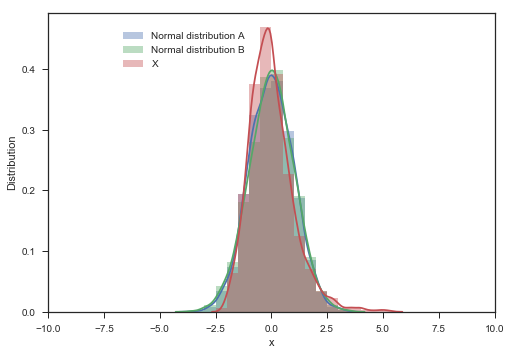

In [5]:
import matplotlib as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks")

# Load the example dataset for Anscombe's quartet
#df = sns.load_dataset("anscombe")

bins = np.arange(-10,10,0.5)

# Show the results of a linear regression within each dataset
ax1 = sns.distplot(A,bins=bins,label='Normal distribution A')
ax2 = sns.distplot(B,bins=bins,label='Normal distribution B')
ax3 = sns.distplot(X,bins=bins,label='X')

plt.pyplot.xlabel('x')
plt.pyplot.ylabel('Distribution')
plt.pyplot.legend(bbox_to_anchor=(0.45, 0.95), loc=0, borderaxespad=0.)

plt.pyplot.xlim((-10,10))
plt.pyplot.show()

<a id='section2' ></a>

## Q - Q test   
This is a visual test to tell whether two distributions are similar.   
We plot the quartiles a given distribution vs. those of another distribution.  
In this case, I compare X vs. a normal distribution to tell whether X is normal.

In [6]:
def get_quartiles(X,Y):
    """Gets 100 quartiles for distributions X and Y
    returns Q1, Q2 with the corresponding quartiles"""
    # Get quartiles, 100 of them
    Q1 = []; Q2=[]
    nq = 10
    n1 = len(X)
    n2 = len(Y)
    for i in range(nq):
        j1 = int(i * n1/nq)
        j2 = int(i * n2/nq)
        # quartiles for the two distributions will be stored in X and Y respectively
        Q1.append(X[j1])
        Q2.append(Y[j2])
    Q1 = np.array(Q1)
    Q2 = np.array(Q2)
    return Q1, Q2

def plot_q_q(Q1,Q2):
    """Makes q-q plot
    Input Quartiles for two distributions"""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    line1, = ax.plot(Q1, Q1, '--', linewidth=2,
                 label='')
    line2, = ax.plot(Q1,Q2, linestyle = 'dotted', linewidth = 4,
                 label='Q-Q')
    #ax.legend(loc='lower right')
    ax.set_title('Q - Q plot')
    ax.set_ylabel('Distribution 2')
    ax.set_xlabel('Distribution 1')
    plt.show()


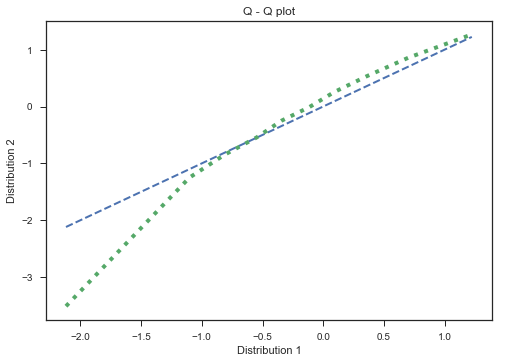

In [7]:
Q1, Q2 = get_quartiles(X,A)
plot_q_q(Q1,Q2)


With the above plot, Distribution X deviates from normal at lower values.
  
For comparison, let's do the same test with a distribution that we know is normal:

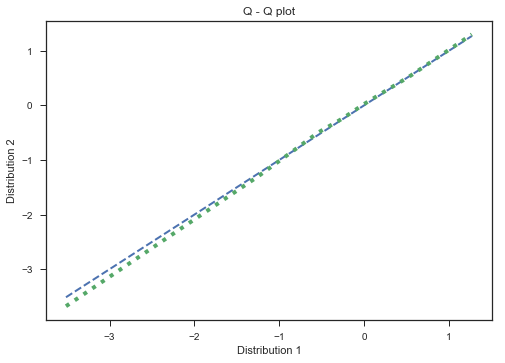

In [8]:
Q1, Q2 = get_quartiles(A,B)
plot_q_q(Q1,Q2)


<a id='section3'></a>
## Skew and Kurtosis test

Here I use the scipty stats implementation of the Ficher skew S and kurtosis K tests.   
We want to know if skew and kurtosis of our sample differ significantly from those of a normal distribution.   

### Skew test:
$H_0$: skew = 0   
$H_1$: skew $\neq$ 0

### Kurtosis test
$H_0$: kurtosis = 0   
$H_1$: kurtosis $\neq$ 0   

### p-values   
We can then obtain the z-scores using:    
$z_\mathrm{skewness} = \frac{S - 0}{\mathrm{SE}_\mathrm{skewness}}$

$z_\mathrm{kurtosis} = \frac{K - 0}{\mathrm{SE}_\mathrm{kurtosis}}$

The standard error for skewness and kurtosis can be obtained in any statistics package. Next, I use the implementation of numpy to get the p-values directly.

In [9]:
from scipy import stats

# Test our initial distribution
printmd('## Skew and Kurtosis tests for a random distribution')
printmd('#### Is our X distribution normal?')
print('Normal skew test teststat     = %6.3f pvalue = %6.4f' % stats.skewtest(X))
print('Normal kurtosis test teststat = %6.3f pvalue = %6.4f' % stats.kurtosistest(X))
printmd('**Conclusion** The pvalue for both tests are zero, meaning that we can reject $H_0$\n')
printmd('This conclusion is telling that X is not normal')

printmd('#### Comparison of 2 normal distributions')
printmd('For the sake of comparison, we repeat the test for a distribution which is actually normal')
printmd('Skew and Kurtosis tests for a normal random distribution')
print('Normal skew test teststat     = %6.3f pvalue = %6.4f' % stats.skewtest(A))
print('Normal kurtosis test teststat = %6.3f pvalue = %6.4f' % stats.kurtosistest(A))
printmd('**Conclusion** The pvalue for both tests are $>$ 0.05, so we accept $H_0$\n')
printmd('This means that A and B are similar, as expected since these two are actual normal distributions')



## Skew and Kurtosis tests for a random distribution

#### Is our X distribution normal?

Normal skew test teststat     = 21.912 pvalue = 0.0000
Normal kurtosis test teststat = 14.480 pvalue = 0.0000


**Conclusion** The pvalue for both tests are zero, meaning that we can reject $H_0$


This conclusion is telling that X is not normal

#### Comparison of 2 normal distributions

For the sake of comparison, we repeat the test for a distribution which is actually normal

Skew and Kurtosis tests for a normal random distribution

Normal skew test teststat     =  0.992 pvalue = 0.3211
Normal kurtosis test teststat = -0.444 pvalue = 0.6569


**Conclusion** The pvalue for both tests are $>$ 0.05, so we accept $H_0$


This means that A and B are similar, as expected since these two are actual normal distributions

<a id='section4'></a>
## Kolmogorov-Smirnov test   

This test relies on computing the larger distance between two CDF distributions.   
Let's look at the CDFs for a test X distribution and a normal distribution A, see [CDF](https://github.com/trangel/stats-with-python/blob/master/notebooks/CDF.ipynb).   

In [10]:
# Get CDF functions:

from scipy.stats import norm
from scipy.special import kolmogorov

# Get CDF for X, this may not be the most effective or elegant way to do this:
percentiles = np.arange(0,1,(1.0-0.0)/len(X))*100.0
CDF_X=[]; Values=[]
for percentile in percentiles:
    Values.append(np.percentile(X,percentile))
    CDF_X.append(percentile/100.0)
CDF_X=np.array(CDF_X)
Values=np.array(Values)


# CDF for a normal distribution, using the same points as for X
rv = norm()
CDF_A = rv.cdf(Values)

# Get the maximum distance between the two distributions:
KS_statistic = (CDF_X - CDF_A).max()
# Get the index for the max. between the two distributions, for plotting
KS_index = (CDF_X - CDF_A).argmax()

# Get the pvalue from the corresonding scipy function:
# https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.special.kolmogorov.html
pvalue=kolmogorov(np.sqrt(len(X))*KS_statistic)
printmd("KS statistic = {}".format(KS_statistic))
printmd("pvalue = {}".format(pvalue))

KS statistic = 0.07507716292933508

pvalue = 1.5184814381659784e-18

The pvalue corresponding to the KS statistic is virtually zero.    
Let's visualize the CDF functions.    

-2.11920877783 5.32355633139 0.01


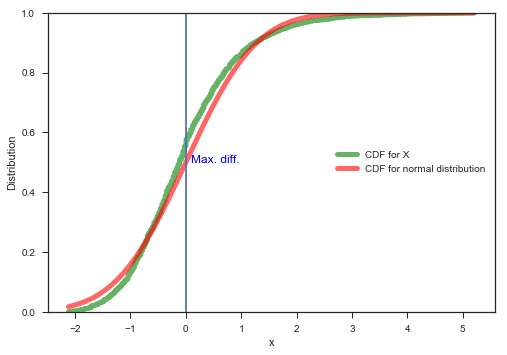

In [11]:
import matplotlib as plt
xmax = X.max()
xmin = X.min()
xstep = 0.01

print(xmin,xmax,xstep)

xx = np.arange(xmin,xmax,xstep)

fig, ax = plt.pyplot.subplots()

ax.plot(Values, CDF_X, 'g-', lw=5, alpha=0.6, label = 'CDF for X' )
ax.plot(Values, CDF_A, 'r-', lw=5, alpha=0.6, label = 'CDF for normal distribution')

ax.axvline(x=X[KS_index])

ax.text(0.1 , 0.5, r'Max. diff.',color='b')

#plt.xlim(-3,7)
plt.pyplot.ylim(0,1)

ax.legend(loc='right')
#ax.set_title('PDF function')
ax.set_ylabel('Distribution')
ax.set_xlabel('x')


plt.pyplot.show()

As shown in the figure, the KS statistic is the maximum difference between the two CDF functions (blue line).    

Now let's make the same test with the scipy's implementation    

In [12]:
stats.kstest(X,'norm',N=len(X))

KstestResult(statistic=0.075347360173323219, pvalue=1.1239640145428811e-18)

The Kolmogorove-Smirnov test is also telling that X is significantly different from a normal distribution. This test is related to the larger difference between the 2 CDFs, compare green and red lines above.    

As we saw in the Q-Q plot, the left-end fraction of the data (lowest values) deviate from a normal distribution, which may be the reason why the Kurtosis, Skew and KS tests tell give a low p-value.    


<a id='Shapiro_Wilk_test'></a>   
## Shapiro-Wilk test    

The Shapiro-Wilk test is a powerful tell to test normality of a distribution.    
The formula uses some $a$ constats, so we will only use the scipy's implementation.    

Further reading    
https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test    


In [13]:
from scipy import stats
stats.shapiro(X)

(0.9486389756202698, 3.8046096076462236e-34)

Again in agreement with other tests, the p-value is low and thus we can reject the null hypothesis that the distribution is normal.

<a id='Anderson_Darling_test'></a>
## Anderson-Darling test    

The Anderson-Darling test is a modification of the Kolmogorov-Smirnov test for the null hypothesis that a sample is drawn from a population that follows a particular distribution.   


In [14]:
stats.anderson(X, dist='norm')

AndersonResult(statistic=33.926298546550242, critical_values=array([ 0.575,  0.655,  0.786,  0.917,  1.091]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

Scipy gives lists of *significance levels* and their corresponding *critical values*, for which if the test-statistic is higher then we can reject the null hypothesis.    
In this case, the test statistic is 33.9 much higher than the critical values reported (for any significance level from 1. to 15.). Therefore, we can safely reject the null hypothesis that the sample is drawn from a population with normal distribution.   

# Summary   

* In this notebook, I revised a couple of methods to test if a distribution is normal.   
* I test a real distribution X from my Insight project as a toy model.   
* I show the usage of Skew, Kurtosis and Kolmogorov-Smirnov, Shapiro-Wilk and Anderson-Darling tests with scipy.    

If you wonder which normality test may be better to use:    

```Monte Carlo simulation has found that Shapiro–Wilk has the best power for a given significance, followed closely by Anderson–Darling when comparing the Shapiro–Wilk, Kolmogorov–Smirnov and Lilliefors tests [1].```

[1] Razali, Nornadiah; Wah, Yap Bee (2011). "Power comparisons of Shapiro–Wilk, Kolmogorov–Smirnov, Lilliefors and Anderson–Darling tests" (PDF). Journal of Statistical Modeling and Analytics. 2 (1): 21–33. Retrieved 30 March 2017.